# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
# Requiere la carpeta de scripts ml
%matplotlib inline
# Auxiliary
from aux_func import *

np.random.seed(0)  # Para mayor determinismo

## Carga de datos

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [2]:
dataset = pd.read_csv("loan_data.csv", comment="#")
display(dataset.head())

# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106


In [3]:
# Antes de seguir y dividir los sets observemos que el set este completo
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1854 entries, 0 to 1853
Data columns (total 11 columns):
TARGET     1854 non-null int64
LOAN       1854 non-null int64
MORTDUE    1854 non-null float64
VALUE      1854 non-null float64
YOJ        1854 non-null float64
DEROG      1854 non-null float64
DELINQ     1854 non-null float64
CLAGE      1854 non-null float64
NINQ       1854 non-null float64
CLNO       1854 non-null float64
DEBTINC    1854 non-null float64
dtypes: float64(9), int64(2)
memory usage: 159.4 KB


0    1545
1     309
Name: TARGET, dtype: int64
Razon - Sin Devolucion / Devolucion:  0.2


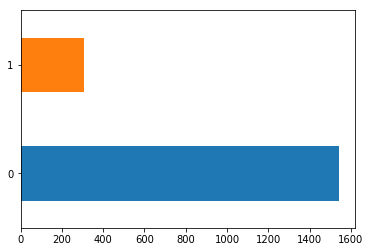

In [4]:
#Observamos que el data set está completo y no tiene variables categoricas.
# Veamos la distribucion de eventos TARGET
print(dataset.TARGET.value_counts())
dataset.TARGET.value_counts().plot("barh")
print('Razon - Sin Devolucion / Devolucion: ',dataset.TARGET.value_counts()[1]/dataset.TARGET.value_counts()[0])

Vemos que las clases estan desbalancedas.Podiria ser necesario hacer undersampling por ejemplo. Pero en esta instancia lo anotamos y seguimos adelante (de ser necesario retornamos a esta instancia)

## Ejercicio 1: División de datos en conjuntos de entrenamiento y evaluación

La primer tarea consiste en dividir el conjunto de datos cargados en el apartado anterior en conjuntos de entrenamiento (o *training*) y evaluación (o *test*).

El primero será utilizado para la creación/selección del modelo de clasificación. El segundo se utilizará sólo al final (una vez elegidos los mejores hiperparámetros) para ver cuál es el resultado final del modelo sobre un conjunto de datos independiente.

In [7]:
# TODO: Dividir en datos de entrenamiento y evaluación
from sklearn.model_selection import  train_test_split
# Utilizamos un esquema similar al planteado en las clases y utilizamos el 80% de los datos para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
print('Entrenamiento -- Razon - Sin Devolucion / Devolucion: ',y_train.value_counts()[1]/y_train.value_counts()[0])
print('Test -- Razon - Sin Devolucion / Devolucion: ',y_test.value_counts()[1]/y_test.value_counts()[0])

Entrenamiento -- Razon - Sin Devolucion / Devolucion:  0.20373376623376624
Test -- Razon - Sin Devolucion / Devolucion:  0.1853035143769968


## Ejercicio 2: Elección de un modelo

Para la elección de un modelo teniamos ciertas instancias.

- Selección de hipótesis
- Selección de regularizador
- Selección de función de coste

#### Justificación de las selecciones

Para el problema en cuestion tenemos un caso de seleccion binaria a priori podriamos usar un esquema tipo logistico o un perceptron por ejemplo. Pero dadas estas dos situaciones no me queda clara cual seria la elección adecuada. Para este punto podemos utilizar un esquema similar al presentado en la clase 4 y en funcion de lo que observemos seleccionamos un modelo en particular. Tanto el regularizador (o penalidad) como la funcion de costo (loss) aparecen en forma explicita en lo siguiente. Adicionalmente vamos a incluir en la busqueda el "l1_ratio" para evaluar la proporcion de l1/l2 en elasticnet. Tambien vamos a remover el reporte de clasificacion sobre el test de validacion puesto que lo evaluaremos mas adelante.

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Exploración de hiperparámetros para función de coste "log"

Mejor conjunto de parámetros:
{'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0.75, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.697 (+/-0.070) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 1, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0.75, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0.5, 'learning_rate': 'constant'}
Exactitud: 0.826 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0.25, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0, 'learning_rate': 'constant'}
Exactitud: 0.815 (+/-0.001) para los parámetros {'alpha': 0.5, 'eta0': 0.1, 'l1_ratio': 1, 'learning_rate': 'constant'}
Exactitud: 0.831 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0.1, 'l1_

/home/felix/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Exploración de hiperparámetros para función de coste "perceptron"

Mejor conjunto de parámetros:
{'alpha': 0.5, 'eta0': 0.001, 'l1_ratio': 0.5, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.830 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 1, 'learning_rate': 'constant'}
Exactitud: 0.575 (+/-0.098) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0.75, 'learning_rate': 'constant'}
Exactitud: 0.566 (+/-0.105) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0.5, 'learning_rate': 'constant'}
Exactitud: 0.566 (+/-0.105) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0.25, 'learning_rate': 'constant'}
Exactitud: 0.699 (+/-0.070) para los parámetros {'alpha': 0.5, 'eta0': 0.5, 'l1_ratio': 0, 'learning_rate': 'constant'}
Exactitud: 0.823 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0.1, 'l1_ratio': 1, 'learning_rate': 'constant'}
Exactitud: 0.829 (+/-0.000) para los parámetros {'alpha': 0.5, 'eta0': 0

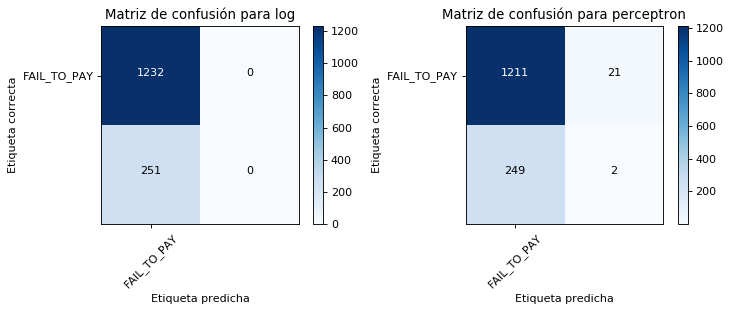

In [9]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

for idx, loss in enumerate(('log', 'perceptron'), start=1):
    exploring_params = {
        'learning_rate': ['constant'],
        'eta0': [0.5, 0.1, 0.01, 0.001],  # Tasa de entrenamiento
        'alpha': [0.5, 0.1, 0.01, 0.001],  # Tasa de regularización
        'l1_ratio':[1,0.75,0.5,0.25,0]
    }
    m = SGDClassifier(loss=loss, penalty='elasticnet',tol=1e-3)
    model = GridSearchCV(m, exploring_params, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")

    print("Puntajes de la grilla:", end="\n\n")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
    print()

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de entrenamiento):", end="\n\n")
    y_true, y_pred = y_train, model.predict(X_train)
    print(classification_report(y_true, y_pred), end="\n\n")
    
    print("================================================", end="\n\n")

    plt.subplot(1, 3, idx)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=['FAIL_TO_PAY'], title="Matriz de confusión para %s" % loss)

A partir de lo observado en las lineas anteriores a priori ambos modelos otorgan resultados similares (para la metrica utilizada, que puede no ser la correcta). Por lo que vamos a seguir con el primero de ellos (logistic)

## Ejercicio 3: Selección de hiperparámetros

Utilizando búsqueda exhaustiva (*grid search*) con *5-fold cross-validation* y utilizando como métrica el área bajo la curva de ROC (o *ROC-AUC*), hagan una selección de los mejores hiperparámetros para su conjunto de datos y el modelo que hayan elegido en el apartado anterior.

# Exploración de hiperparámetros para función de coste "log"

Mejor conjunto de parámetros:
{'alpha': 0.0001, 'eta0': 0.25, 'l1_ratio': 0.75, 'learning_rate': 'constant'}

Puntajes de la grilla:

Exactitud: 0.550 (+/-0.001) para los parámetros {'alpha': 0.75, 'eta0': 0.75, 'l1_ratio': 1, 'learning_rate': 'constant'}
Exactitud: 0.533 (+/-0.002) para los parámetros {'alpha': 0.75, 'eta0': 0.75, 'l1_ratio': 0.75, 'learning_rate': 'constant'}
Exactitud: 0.490 (+/-0.003) para los parámetros {'alpha': 0.75, 'eta0': 0.75, 'l1_ratio': 0.5, 'learning_rate': 'constant'}
Exactitud: 0.547 (+/-0.001) para los parámetros {'alpha': 0.75, 'eta0': 0.75, 'l1_ratio': 0.25, 'learning_rate': 'constant'}
Exactitud: 0.486 (+/-0.004) para los parámetros {'alpha': 0.75, 'eta0': 0.75, 'l1_ratio': 0, 'learning_rate': 'constant'}
Exactitud: 0.537 (+/-0.001) para los parámetros {'alpha': 0.75, 'eta0': 0.5, 'l1_ratio': 1, 'learning_rate': 'constant'}
Exactitud: 0.494 (+/-0.003) para los parámetros {'alpha': 0.75, '

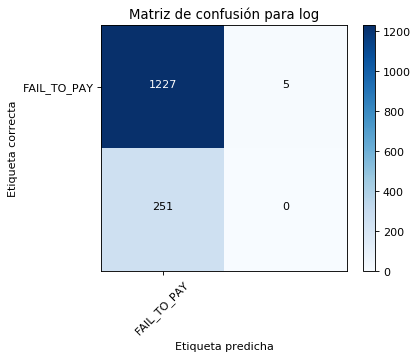

In [19]:
# Si bien ya realizamos una busqueda inicial sobre el espacio de hiperparametros podemos afinar un poco mas la grilla. El esquema es identico a lo anterior
# con la salvedad que afinaremos el espacio de busqueda, disminuiremos la tolerancia, y el scoring
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

idx=1
loss='log'
exploring_params = {
    'learning_rate': ['constant'],
    'eta0': [0.75, 0.5, 0.25, 0.1, 0.01, 0.001,0.0001],  # Tasa de entrenamiento
    'alpha': [0.75, 0.5, 0.25, 0.1, 0.01, 0.001,0.0001],  # Tasa de regularización
    'l1_ratio':[1,0.75,0.5,0.25,0]
}
m = SGDClassifier(loss=loss, penalty='elasticnet',tol=1e-5)
model = GridSearchCV(m, exploring_params, cv=5, scoring='roc_auc')
model.fit(X_train, y_train)

print("# Exploración de hiperparámetros para función de coste \"%s\"" % loss, end="\n\n")

print("Mejor conjunto de parámetros:")
print(model.best_params_, end="\n\n")

print("Puntajes de la grilla:", end="\n\n")
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("Exactitud: %0.3f (+/-%0.03f) para los parámetros %r" % (mean, std ** 2, params))
print()

print("Reporte de clasificación para el mejor clasificador (sobre conjunto de entrenamiento):", end="\n\n")
y_true, y_pred = y_train, model.predict(X_train)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

plt.subplot(1, 3, idx)
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=['FAIL_TO_PAY'], title="Matriz de confusión para %s" % loss)

## Ejercicio 4: Métricas sobre el conjunto de evaluación

Una vez encontrados los mejores hiperparámetros para el modelo seleccionado en los apartados anteriores se evalúa el modelo final entrenado sobre el conjunto de datos de evaluación seleccionado en el ejercicio 1. Pueden utilizar las métricas que crean convenientes. Es mejor utilizar más de una métrica. Particularmente el *reporte de clasificación* y la *matriz de confusión* son buenos ejemplos de métricas.

Reporte de clasificación para el mejor clasificador (sobre conjunto de Validacion):

             precision    recall  f1-score   support

          0       0.84      0.99      0.91       313
          1       0.00      0.00      0.00        58

avg / total       0.71      0.83      0.77       371





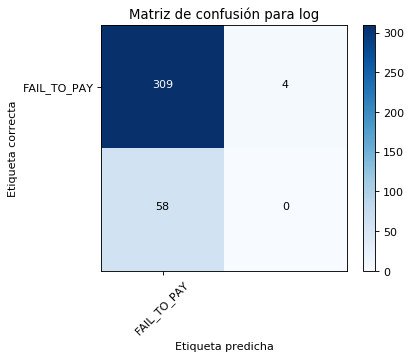

In [21]:
# TODO: Evaluación del modelo
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
# EL mejor fit lo encontramos en el step anterior, entonces invocamos el modelo,
print("Reporte de clasificación para el mejor clasificador (sobre conjunto de Validacion):", end="\n\n")
y_true, y_pred = y_test, model.predict(X_test)
print(classification_report(y_true, y_pred), end="\n\n")

print("================================================", end="\n\n")

plt.subplot(1, 3, idx)
plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                      classes=['FAIL_TO_PAY'], title="Matriz de confusión para %s" % loss)


NO me queda claro que esto este dando buenos resultados. La relacion que otorga la matriz de confusion parece ser la misma que la cantidad de casos que no devuelven el loan sobre la cantidad de los que lo devuelven....
Capaz sea necesario hacer undersampling...

## Ejercicio 5 (opcional): Curvas de ROC

Como ejercicio adicional (opcional), pueden redefinir el umbral de decisión óptimo del problema a partir de los resultados que muestren curvas de ROC como justificación. 

Pueden ver esto mediante la [graficación de las curvas de ROC](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html). En el link que se les brinda se muestra como hacer para graficar curvas de ROC para problemas multiclase. Sin embargo se puede adaptar fácilmente a un problema binario obviando la parte donde se calcula la curva clase por clase.

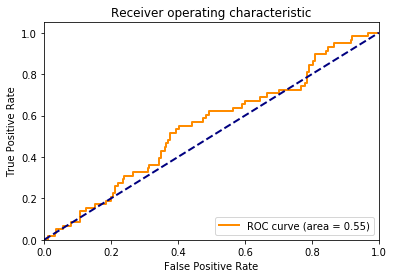

In [29]:
# TODO: Redefinir umbral de clasificación a través de los resultados vistos por graficar curvas de ROC
from sklearn.metrics import roc_curve, auc
y_score = model.decision_function(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

## Graficamos
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()



Analisis en proceso...